In [2]:
%load_ext autoreload

In [99]:
%autoreload
%matplotlib inline
import pandas as pd
import numpy as np
import string
import time
import math
import random


import utils.seq2seq as util
import tasks.date_task as task

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

torch.set_num_threads(10)

In [37]:
train_pairs, val_pairs, input_vocab, output_vocab = task.create_and_load("data", True)
max_attn_length = max([len(x[0]) for x in train_pairs])

In [97]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        # Convert input to dense representation
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        # Compute scores    
        w = hidden[0].matmul(encoder_outputs.transpose(0,1))
        w = F.softmax(w, dim=1)

        # Combine
        z = w.matmul(encoder_outputs)
        
        # Compute output
        output, hidden = self.gru(embedded, hidden.unsqueeze(0))
        output = F.log_softmax(self.out(output[0]), dim=1)
        
        return output, hidden, attn_weights

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))

Epoch 1 of 10
0m 39s (- 31m 17s) (1000 2%) 1.1717
1m 19s (- 30m 31s) (2000 4%) 0.8479
1m 57s (- 29m 24s) (3000 6%) 0.4996
2m 36s (- 28m 38s) (4000 8%) 0.4450
3m 15s (- 27m 57s) (5000 10%) 0.4032
3m 53s (- 27m 16s) (6000 12%) 0.2894
4m 32s (- 26m 35s) (7000 14%) 0.2372
5m 9s (- 25m 48s) (8000 16%) 0.2078
5m 47s (- 25m 7s) (9000 18%) 0.2103
6m 26s (- 24m 29s) (10000 20%) 0.2258
7m 4s (- 23m 49s) (11000 22%) 0.1985
7m 42s (- 23m 6s) (12000 25%) 0.1911
8m 20s (- 22m 28s) (13000 27%) 0.1919
8m 59s (- 21m 50s) (14000 29%) 0.1602
9m 37s (- 21m 11s) (15000 31%) 0.1668
10m 16s (- 20m 32s) (16000 33%) 0.1732
10m 54s (- 19m 54s) (17000 35%) 0.1557
11m 33s (- 19m 15s) (18000 37%) 0.1562
12m 12s (- 18m 37s) (19000 39%) 0.1365
12m 51s (- 17m 59s) (20000 41%) 0.1449
13m 29s (- 17m 20s) (21000 43%) 0.1594
14m 7s (- 16m 41s) (22000 45%) 0.1463
14m 46s (- 16m 4s) (23000 47%) 0.1165
15m 26s (- 15m 26s) (24000 50%) 0.1434
16m 5s (- 14m 48s) (25000 52%) 0.1197
16m 44s (- 14m 9s) (26000 54%) 0.1256
17m 21s 

<Figure size 921.6x633.6 with 0 Axes>

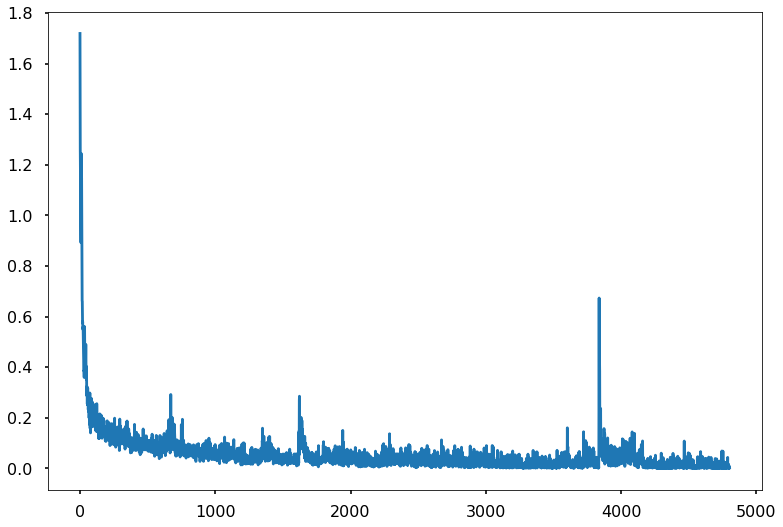

In [103]:
encoder = EncoderRNN(input_vocab.size(), 128)
decoder = AttnDecoderRNN(128, output_vocab.size())
util.train_iters(encoder, decoder, train_pairs, output_vocab, max_attn_length, epochs=10)

> <sos>11/23/10<eos>
= <sos>2010-11-23<eos>
< 2010-11-23<eos>



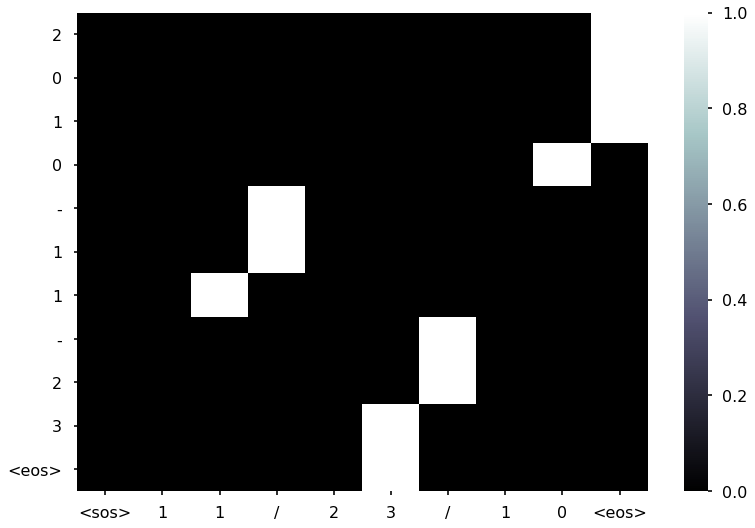

> <sos>MAY 21, 1980<eos>
= <sos>1980-05-21<eos>
< 1980-05-21<eos>



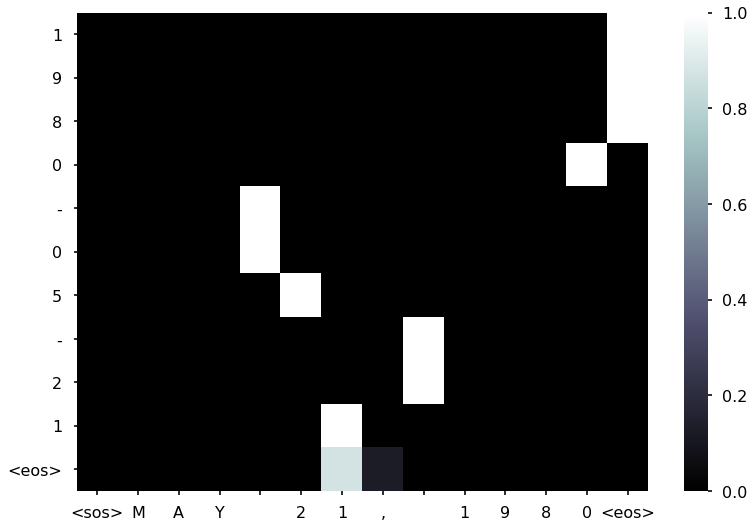

> <sos>17 July, 1974<eos>
= <sos>1974-07-17<eos>
< 1974-07-17<eos>



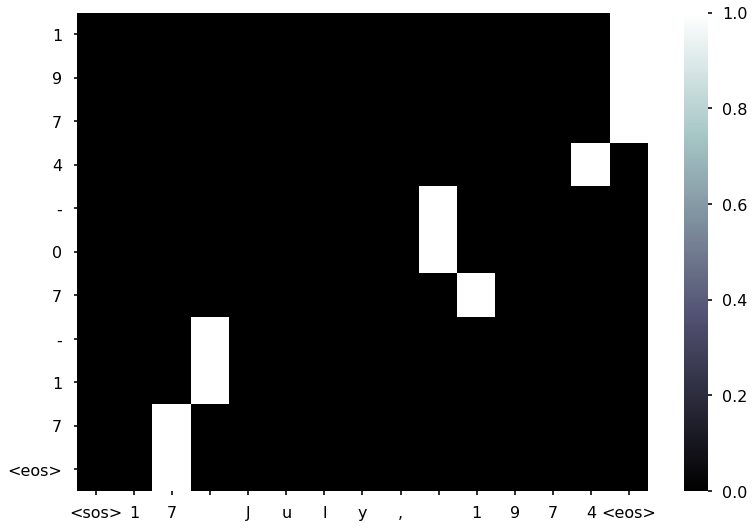

> <sos>july 12, 2004<eos>
= <sos>2004-07-12<eos>
< 2004-07-12<eos>



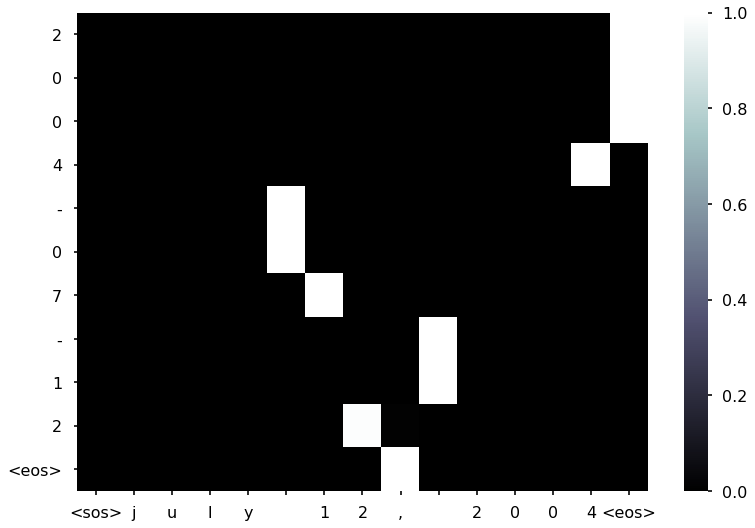

> <sos>9 Jun 2003<eos>
= <sos>2003-06-09<eos>
< 2003-06-09<eos>



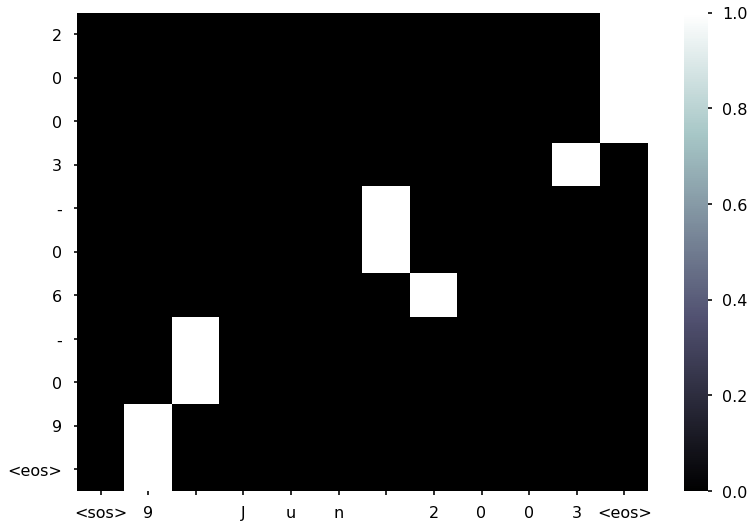

> <sos>9 december, 1980<eos>
= <sos>1980-12-09<eos>
< 1980-12-09<eos>



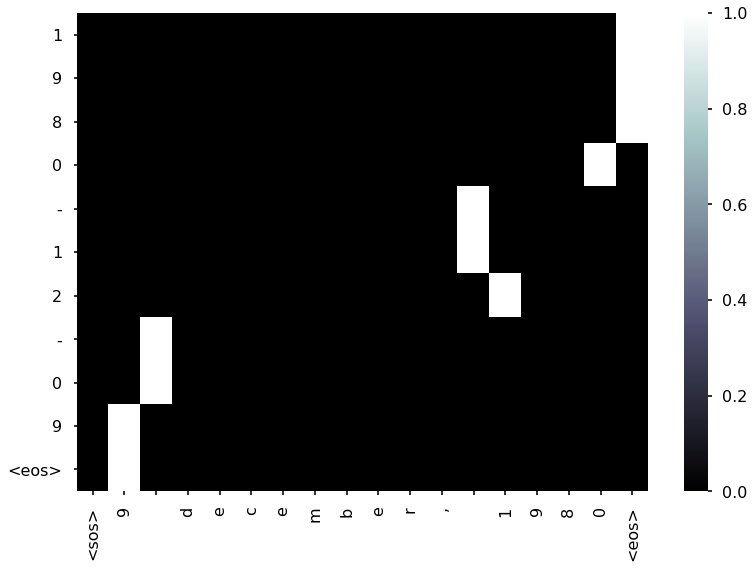

> <sos>10 December 2003<eos>
= <sos>2003-12-10<eos>
< 2003-12-10<eos>



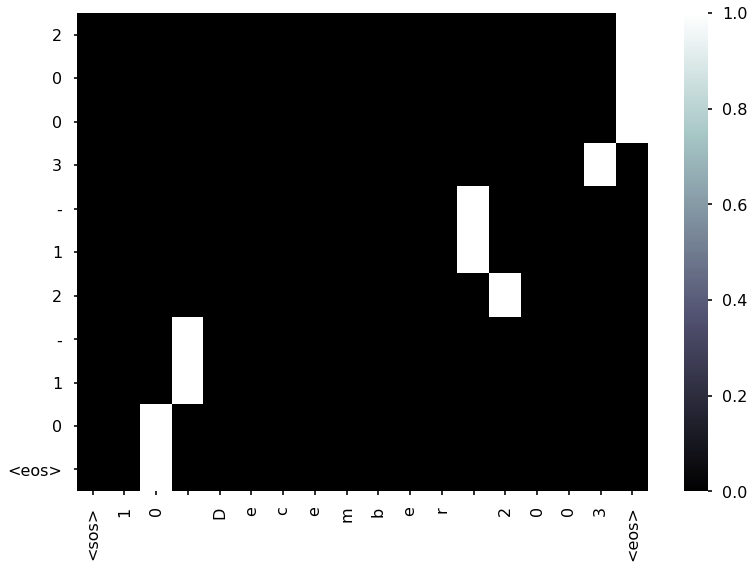

> <sos>26.01.94<eos>
= <sos>1994-01-26<eos>
< 1994-01-26<eos>



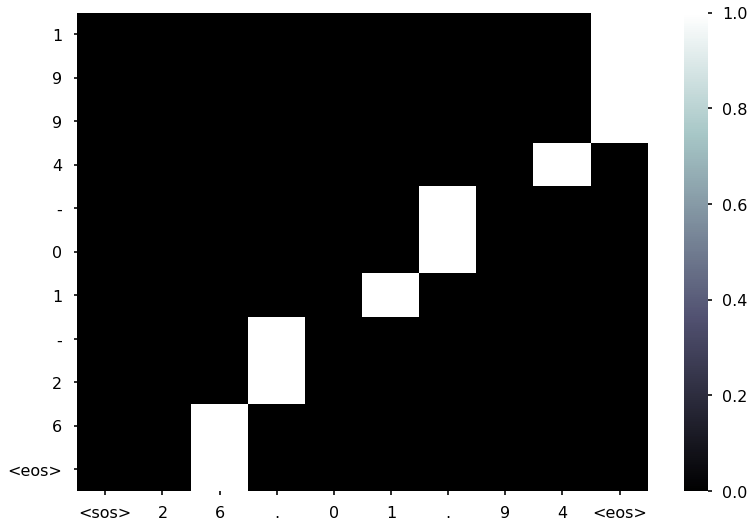

> <sos>2 NOVEMBER 1985<eos>
= <sos>1985-11-02<eos>
< 1985-11-02<eos>



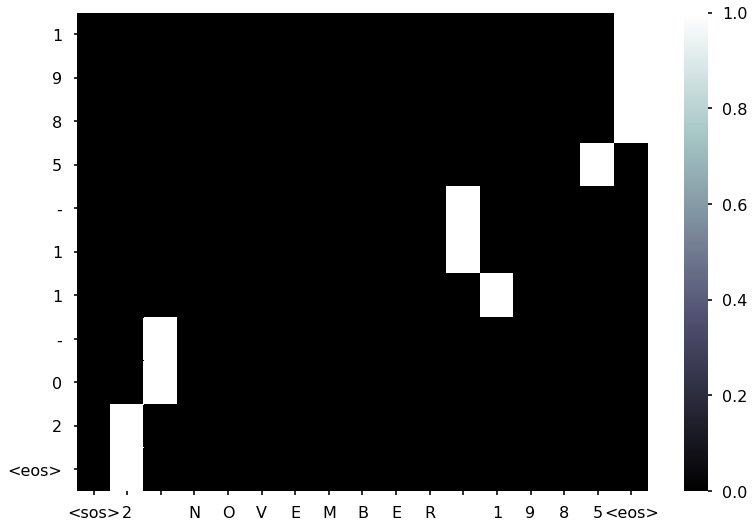

> <sos>13 May 1991<eos>
= <sos>1991-05-13<eos>
< 1991-05-13<eos>



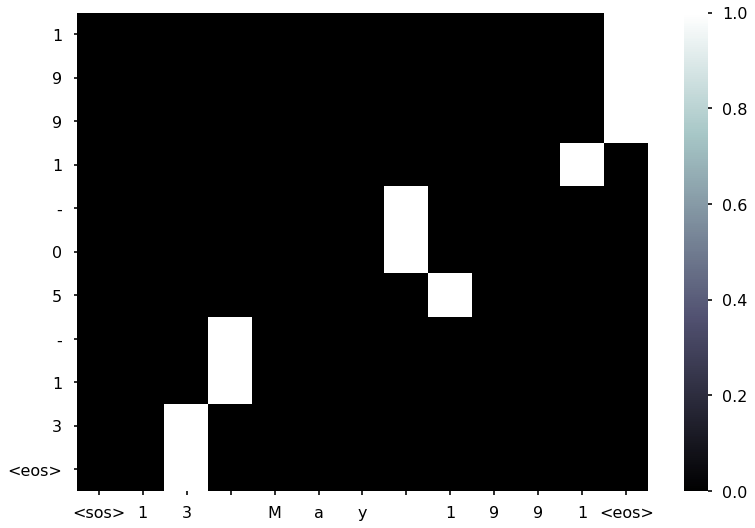

In [104]:
util.evaluate_randomly(encoder, decoder, val_pairs, input_vocab, output_vocab, max_attn_length, n=10)